In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%ls -1 data/

test_seas2_0.871.csv
test_seas_0.104.csv
time_var_shift_10.csv
time_var_shift_250.csv
var_shift_2_5.csv


In [3]:
df_01 = pd.read_csv('data/test_seas_0.104.csv')
df_09 = pd.read_csv('data/test_seas2_0.871.csv')

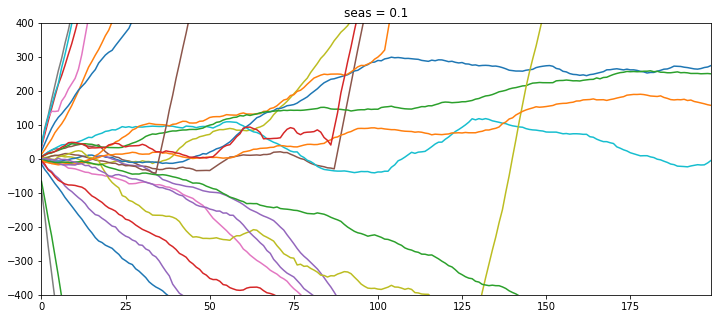

In [4]:
df_01.sample(25, random_state=123, axis=1).\
      plot(linestyle='-',
           marker=None, logy=False,
           legend=False, figsize=(12,5),
           ylim=(-400,400),
           title='seas = 0.1'
          );

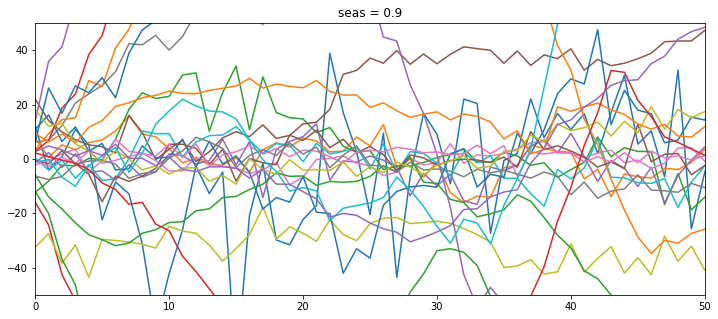

In [5]:
df_09.sample(25,random_state=123, axis=1).\
      plot(linestyle='-', logy=False,
           legend=False, figsize=(12,5),
           ylim=(-50,50), xlim=(0, 50),
           title='seas = 0.9');

## Making datasets + Preprocessing
We do following:

1) add min value to makes TS positive.


3) divide by max in order to make $TS \in [0,1]$.


In [7]:
def norm_ts(data):
    """
    1) just scaler, so  TS∈[0,1] .
    """
    scaler = MinMaxScaler(copy=True)
    scaled01 = scaler.fit_transform(data.T).T
    return scaled01, scaler

def inverse_norm(data, scaler):
    """1) inverse scaling
    """
    return scaler.inverse_transform(data.T).T


In [8]:
data_01 = df_01.values.T
np.random.shuffle(data_01)

data_09 = df_09.values.T
np.random.shuffle(data_09)
data_01_09 = np.concatenate((data_01, data_09), axis=0)
np.random.shuffle(data_01_09)

data_01_norm, scaler01  = norm_ts(data_01)
data_09_norm, scaler09  = norm_ts(data_09)
data_01_09_norm, scaler0109 = norm_ts(data_01_09)




In [9]:
data_01.shape

(10000, 200)

## Let's plot after

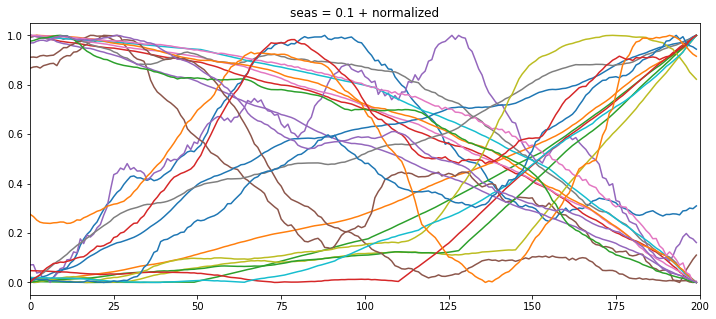

In [50]:
pd.DataFrame(data_01_norm.T).\
                              sample(25, random_state=123, axis=1).\
                              plot(linestyle='-', logy=False,
                              legend=False, figsize=(12,5),xlim=(0, 200),
                              title='seas = 0.1 + normalized');

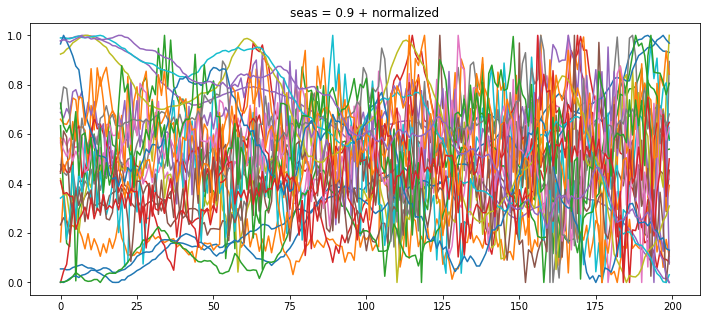

In [51]:
pd.DataFrame(data_09_norm.T).\
                              sample(25, random_state=123, axis=1).\
                              plot(linestyle='-', logy=False,
                              legend=False, figsize=(12,5),
                              title='seas = 0.9 + normalized');

## Checking the back transformation

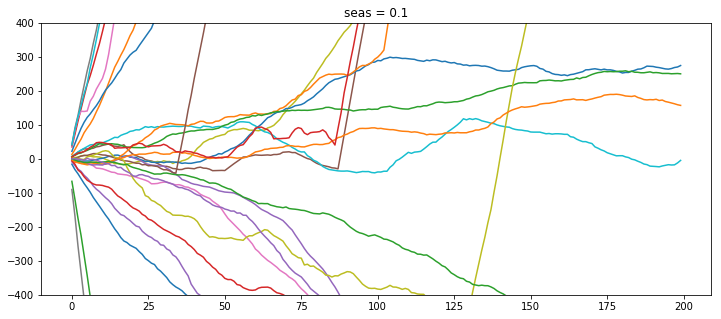

In [43]:
data_01_back_norm = inverse_norm(data_01_norm, scaler01)
pd.DataFrame(data_01_back_norm.T).sample(25, random_state=123, axis=1).\
      plot(linestyle='-',
           marker=None, logy=False,
           ylim=(-400,400),
           legend=False, figsize=(12,5),
           title='seas = 0.1'
          );

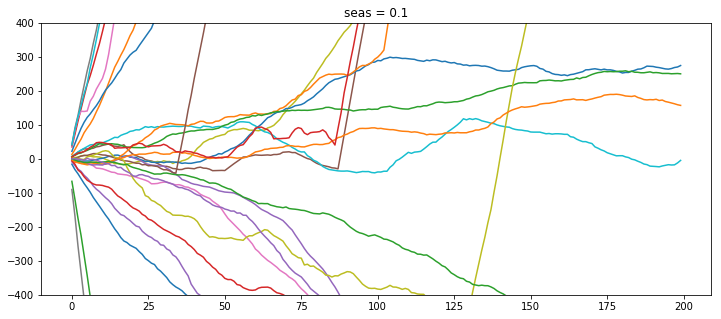

In [44]:
df_01.sample(25, random_state=123, axis=1).\
      plot(linestyle='-',
           marker=None, logy=False,
           legend=False, figsize=(12,5),
           ylim=(-400,400),
           title='seas = 0.1'
          );

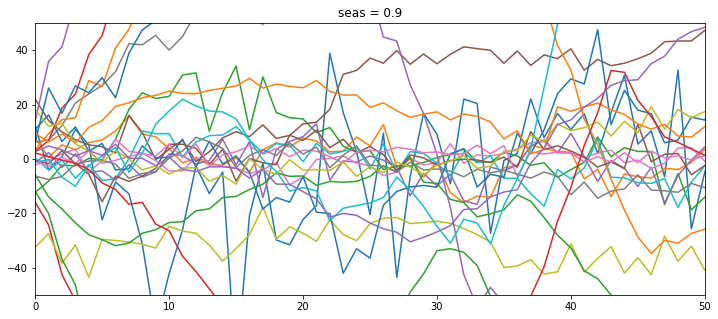

In [47]:
data_09_back_norm = inverse_norm(data_09_norm, scaler09)
pd.DataFrame(data_09_back_norm.T).sample(25,random_state=123, axis=1).\
      plot(linestyle='-', logy=False,
           legend=False, figsize=(12,5),
           ylim=(-50,50), xlim=(0, 50),
           title='seas = 0.9');

In [ ]:
df_09.sample(25,random_state=123, axis=1).\
      plot(linestyle='-', logy=False,
           legend=False, figsize=(12,5),
           ylim=(-50,50), xlim=(0, 50),
           title='seas = 0.9');

In [52]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [53]:
def mse(Y, YH):
     return np.square(Y - YH).mean()
    

def train_test_split_reshape(data, n_steps_for_train=175):
    """reshape + split train test 50-50"""
    n_samples = data.shape[0]
    x_train = data[:n_samples/2, :n_steps_for_train].reshape(n_samples/2, n_steps_for_train, 1)
    y_train = data[:n_samples/2, n_steps_for_train:]

    x_test = data[n_samples/2:, :n_steps_for_train].reshape(n_samples/2, n_steps_for_train, 1)
    y_test = data[n_samples/2:, n_steps_for_train:]
    return x_train, y_train, x_test, y_test


def naive_prediction_mae():
    naive_pred = 0
    n = x_test.shape[0]
    for i in range(n): 
        naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
    naive_pred /= n
    print 'naive model = {0:0.4f}'.format(naive_pred)
    return None

def model_mae(model):
    y_pred = model.predict(x_test)
    mae = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print 'current model = {0:0.4f}'.format(mae)
    return mae

In [54]:
def cnn_model(x_train, y_train, batch_size, epochs=50, n_steps_for_train=175):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=200-input_dim, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

## CNN for 2 cluster together

In [56]:
naive_prediction_mae()
r_01_09 = model_mae(model)

naive model = 0.1600
current model = 0.0687


### Resuts of preprocessing with log

In [10]:
naive_prediction_mae()
r_01_09 = model_mae(model)

naive model = 0.0972
current model = 0.0771


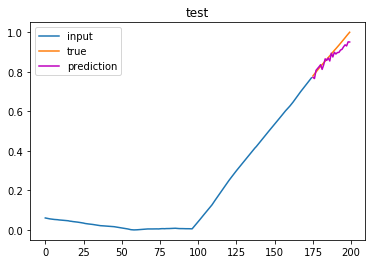

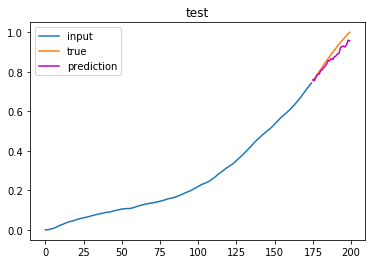

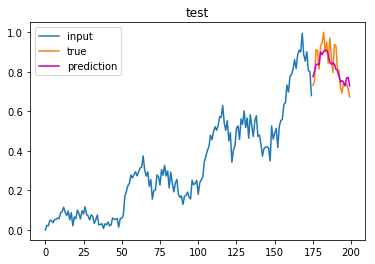

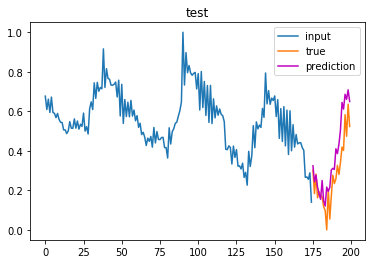

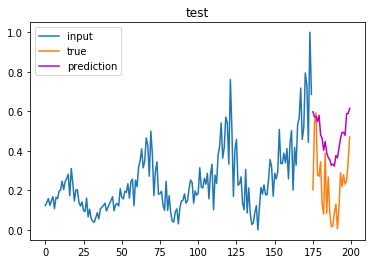

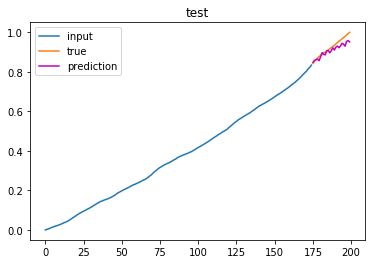

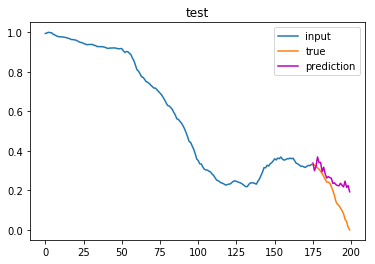

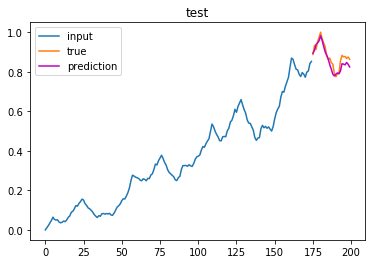

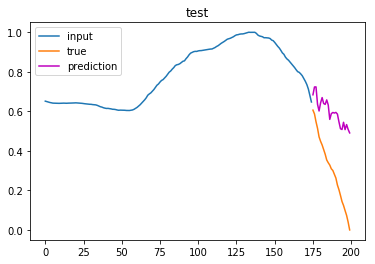

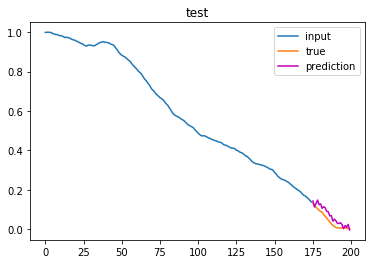

In [57]:
y_pred = model.predict(x_test)
for i in range(10):
    plt.figure()
    plt.plot(range(175), x_test[i], label='input')
    plt.plot(range(175, 200), y_test[i], label='true')
    plt.plot(range(175, 200), y_pred[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

### Resuts of preprocessing with *log*

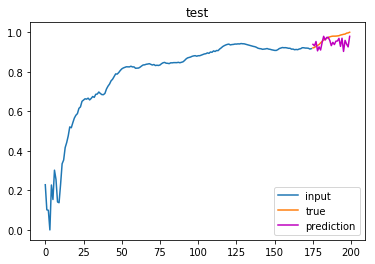

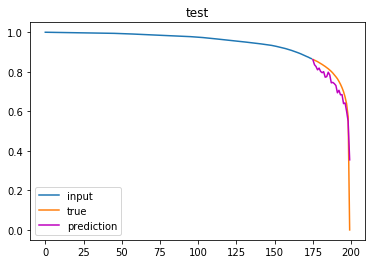

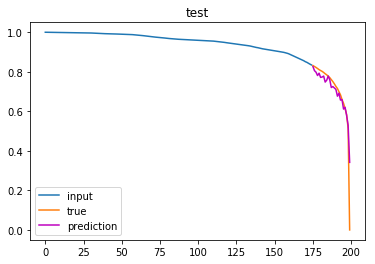

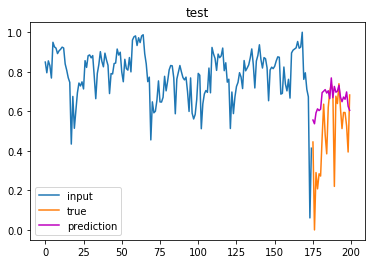

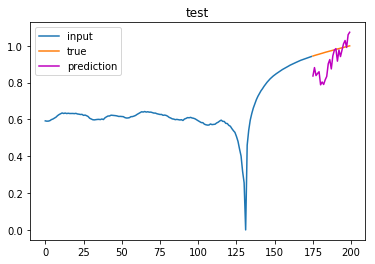

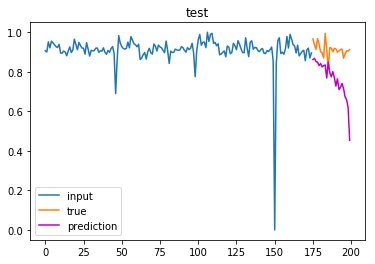

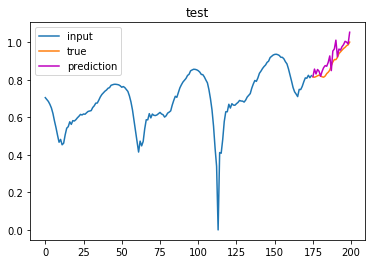

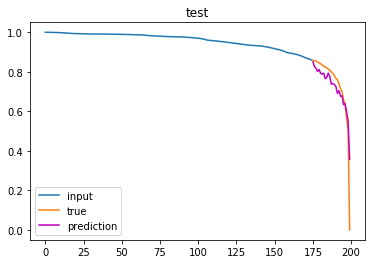

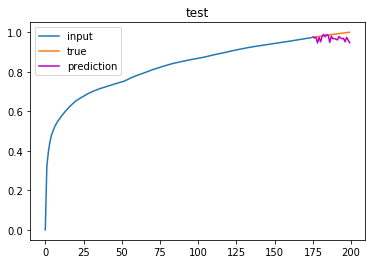

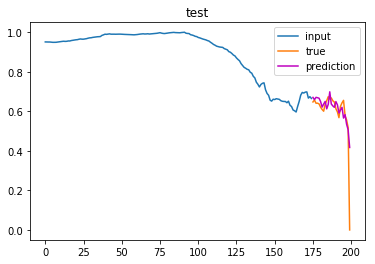

In [11]:
y_pred = model.predict(x_test)
for i in range(10):
    plt.figure()
    plt.plot(range(175), x_test[i], label='input')
    plt.plot(range(175, 200), y_test[i], label='true')
    plt.plot(range(175, 200), y_pred[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

## After Inverse Transformation

/Users/mdymshits/virtualenv/ir-threat/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


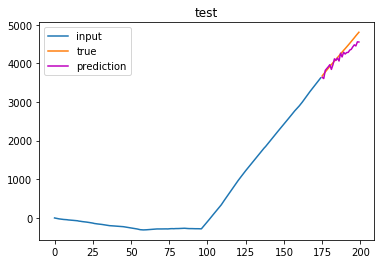

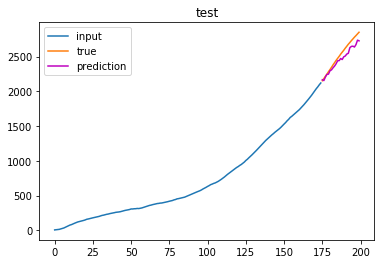

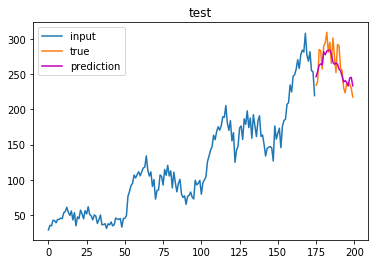

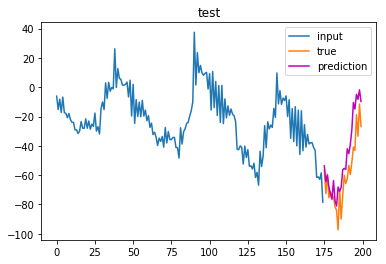

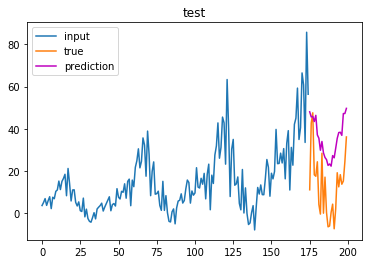

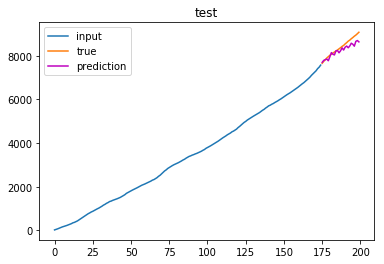

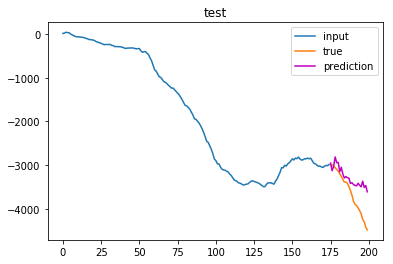

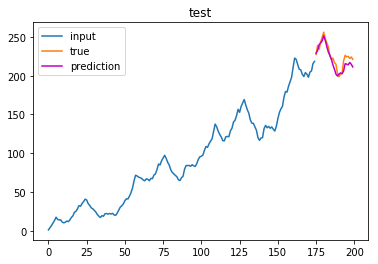

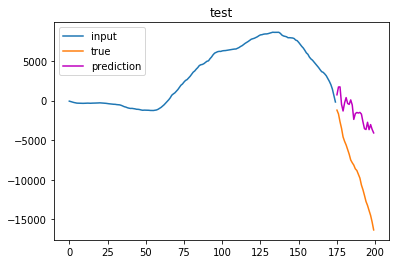

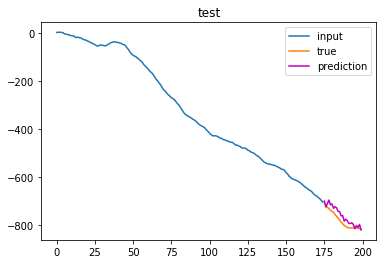

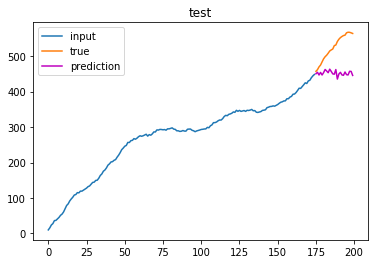

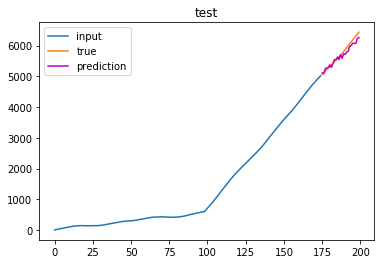

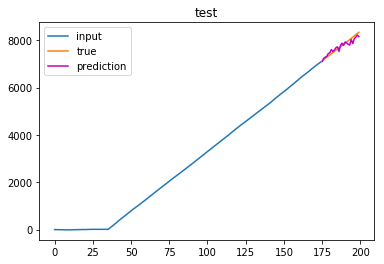

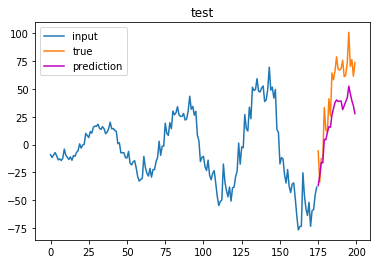

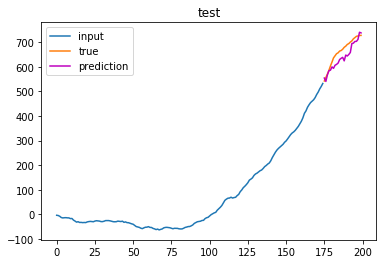

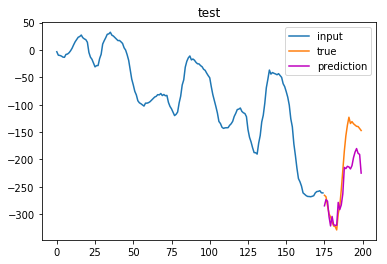

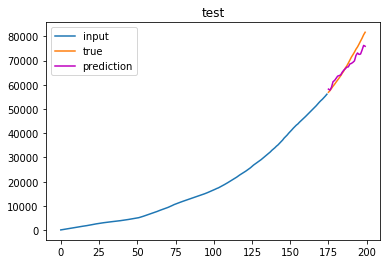

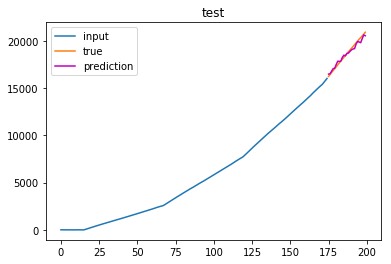

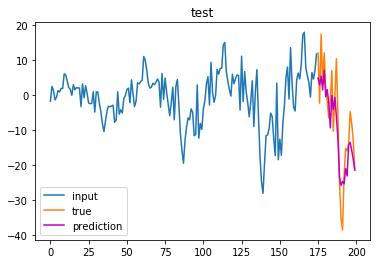

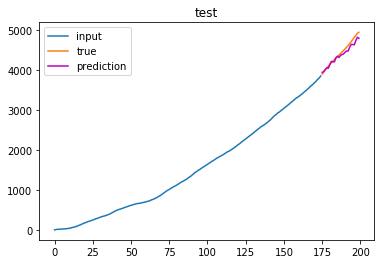

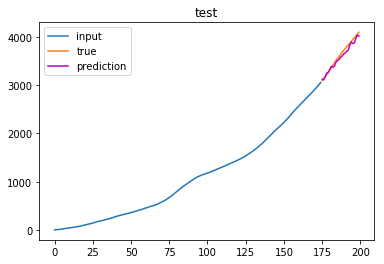

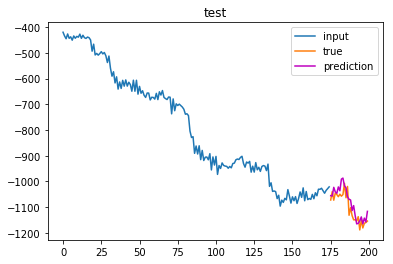

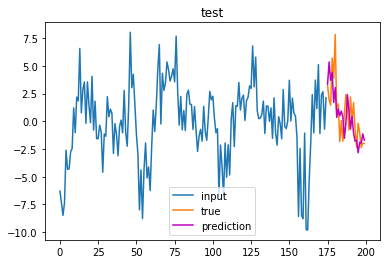

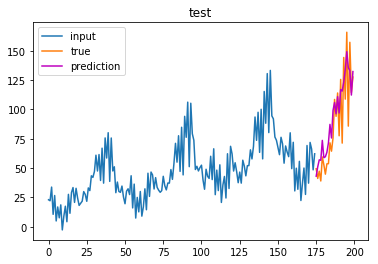

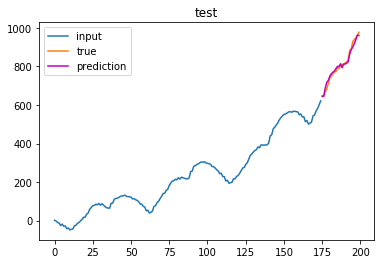

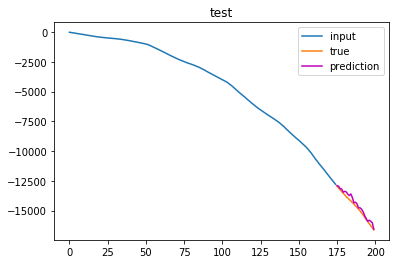

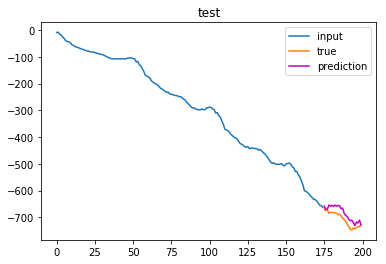

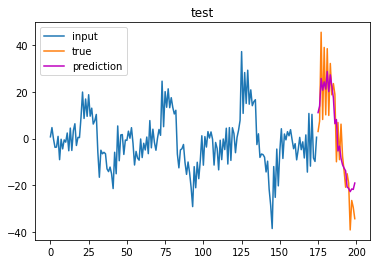

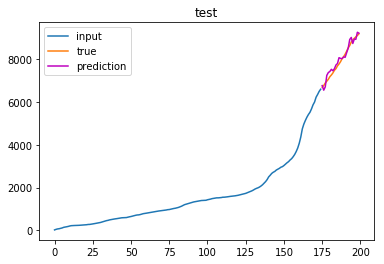

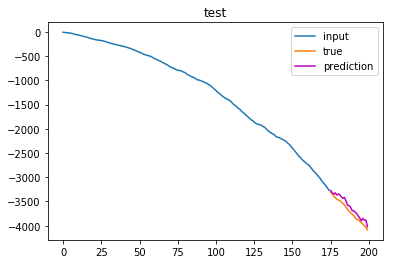

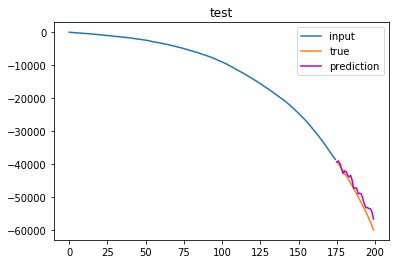

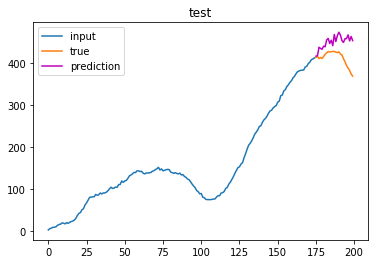

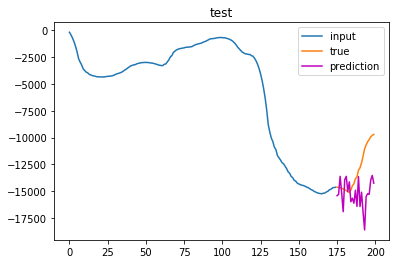

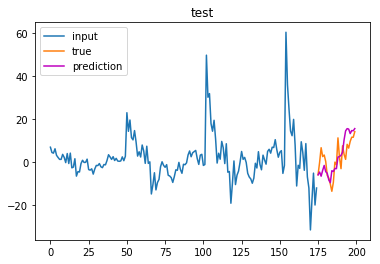

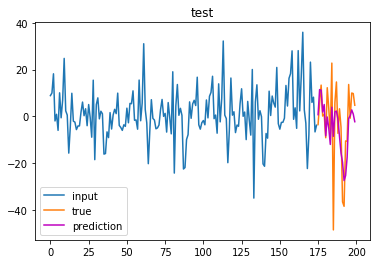

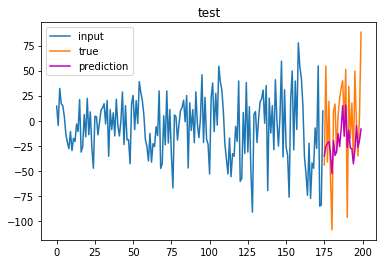

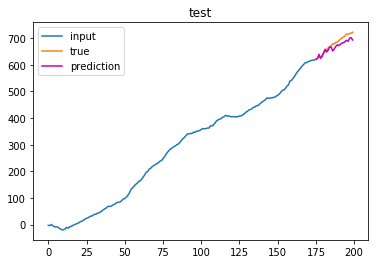

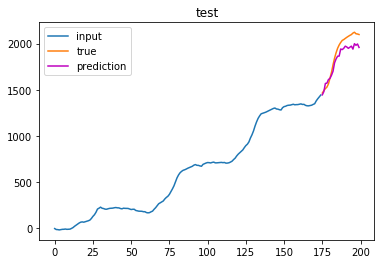

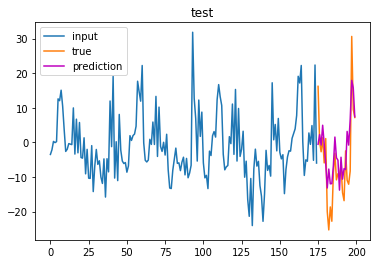

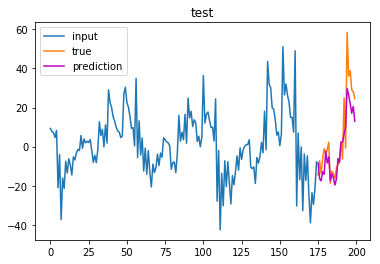

In [59]:
n_steps_for_train = 175
x_all = data_01_09_norm[:, :n_steps_for_train].reshape(data_01_09_norm.shape[0], n_steps_for_train, 1)
n = data_01_09_norm.shape[0] / 2

y_pred = model.predict(x_all)
y_pred_back = inverse_norm(y_pred, scaler0109)[n:, :]


for i in range(40):
    plt.figure()
    plt.plot(range(175), data_01_09[n + i, :175], label='input')
    plt.plot(range(175, 200), data_01_09[n + i, 175:], label='true')
    plt.plot(range(175, 200), y_pred_back[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

## After Inverse Transformation with *log*

/Users/mdymshits/virtualenv/ir-threat/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


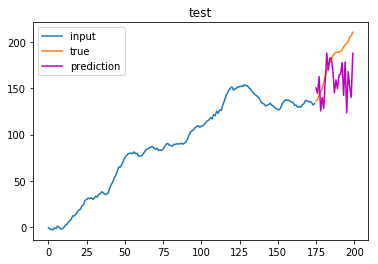

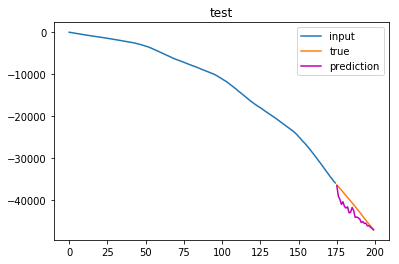

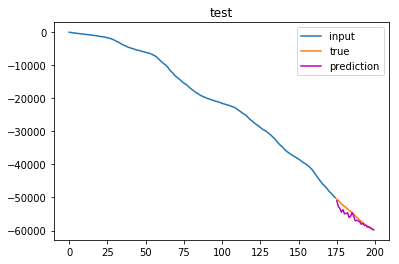

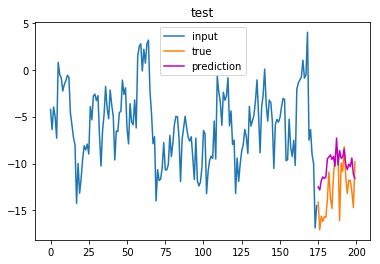

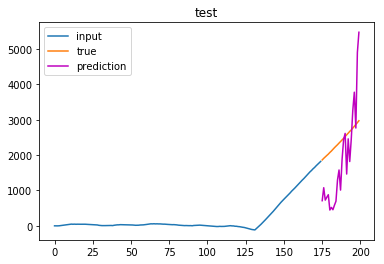

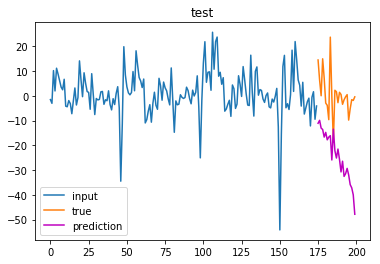

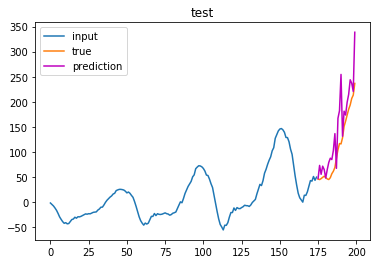

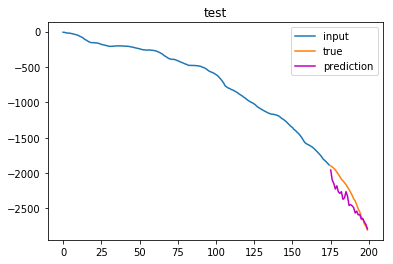

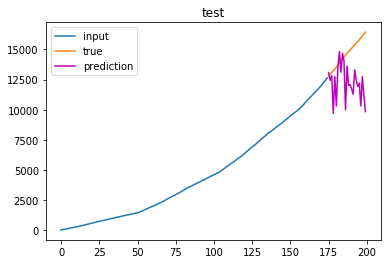

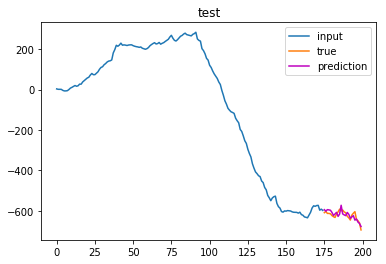

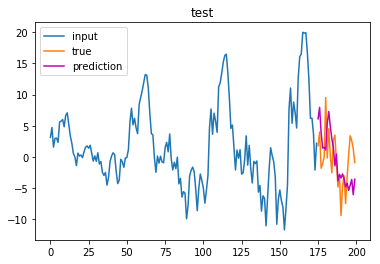

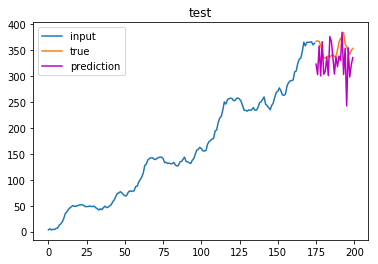

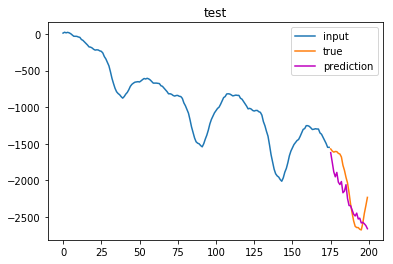

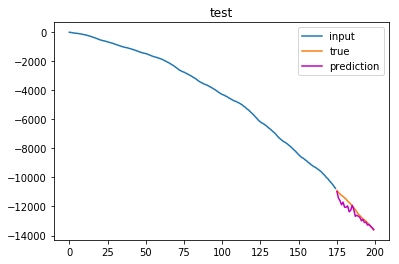

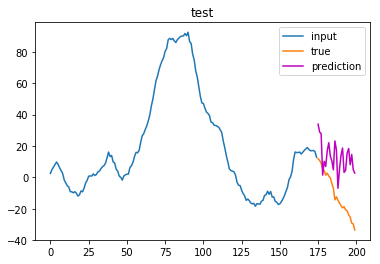

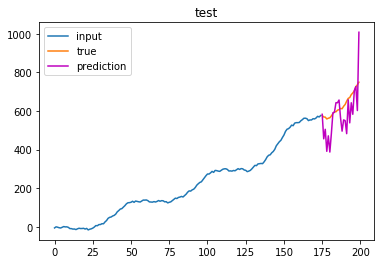

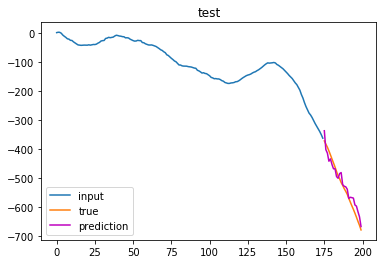

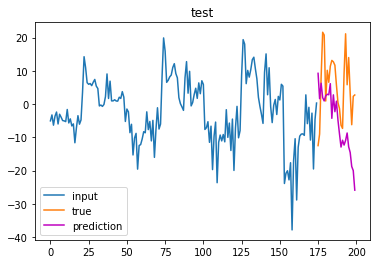

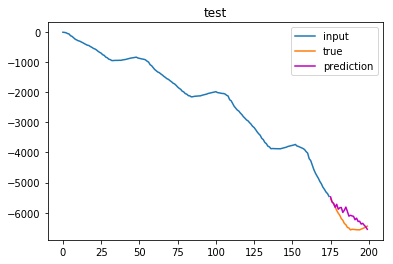

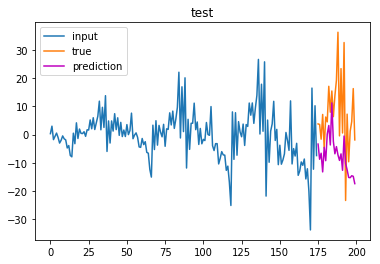

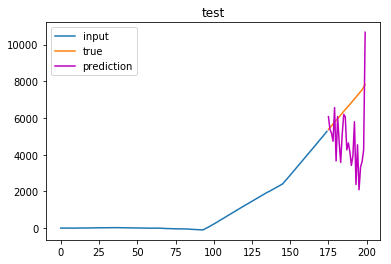

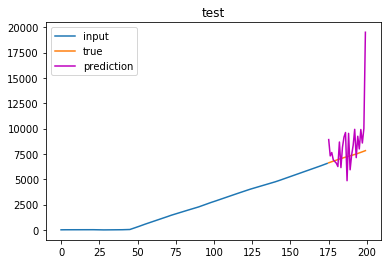

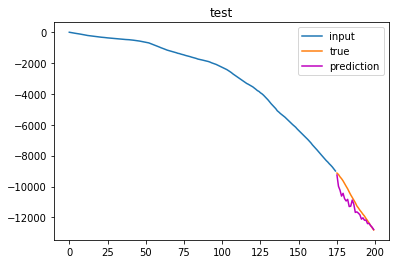

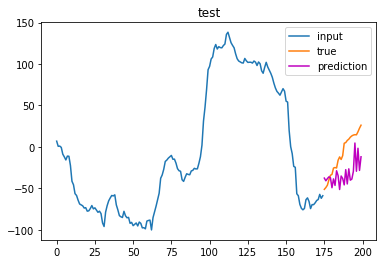

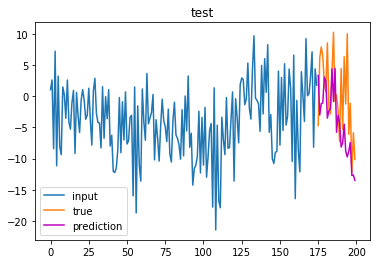

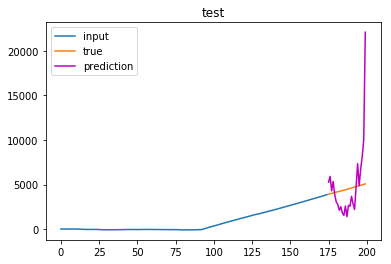

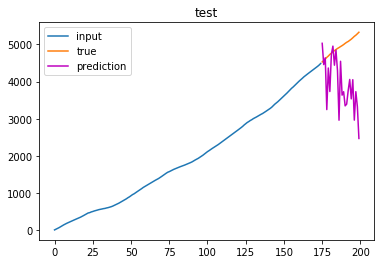

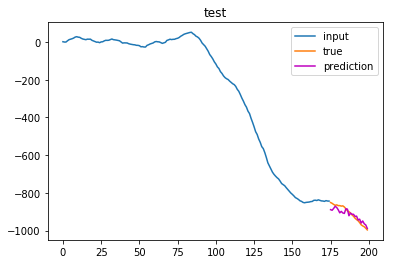

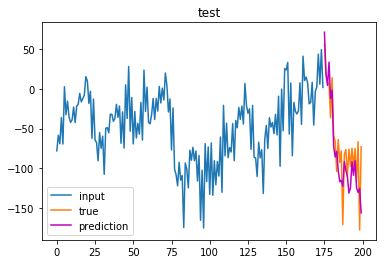

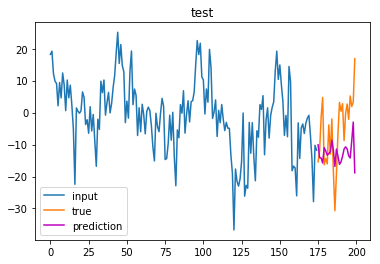

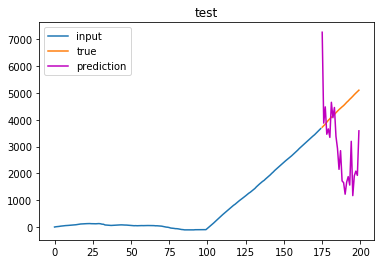

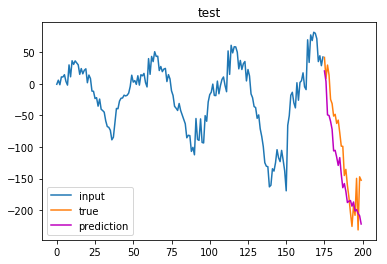

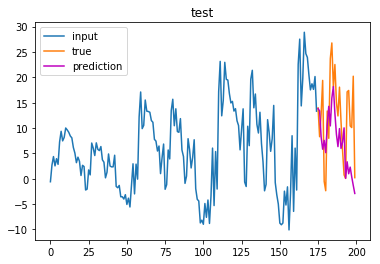

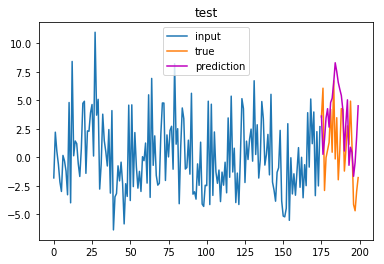

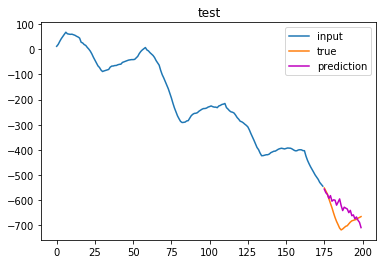

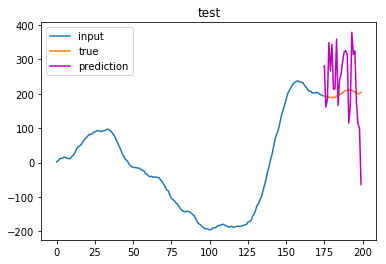

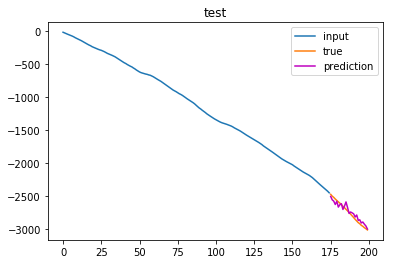

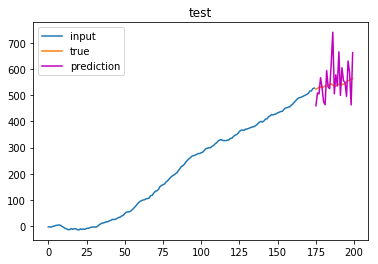

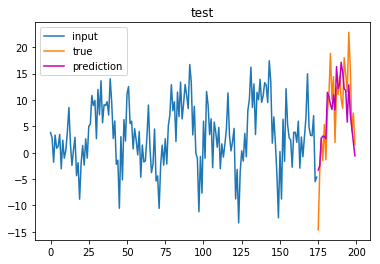

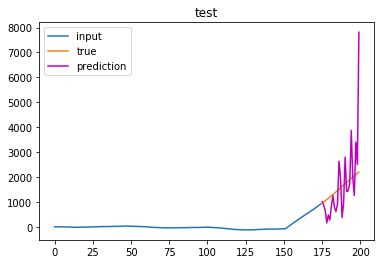

In [12]:
n_steps_for_train = 175
x_all = data_01_09_norm[:, :n_steps_for_train].reshape(data_01_09_norm.shape[0], n_steps_for_train, 1)
n = data_01_09_norm.shape[0] / 2

y_pred = model.predict(x_all)
y_pred_back = inverse_norm(y_pred, scaler0109, min0109)[n:, :]


for i in range(40):
    plt.figure()
    plt.plot(range(175), data_01_09[n + i, :175], label='input')
    plt.plot(range(175, 200), data_01_09[n + i, 175:], label='true')
    plt.plot(range(175, 200), y_pred_back[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

## CNN for "low seasonality cluster"

In [60]:
x_train, y_train, x_test, y_test = train_test_split_reshape(data_01_norm)
model, history = cnn_model(x_train=x_train, y_train=y_train, batch_size=4)

Train on 3500 samples, validate on 1500 samples
Epoch 1/50
 - 2s - loss: 0.0534 - mean_absolute_error: 0.1401 - val_loss: 0.0173 - val_mean_absolute_error: 0.0749
Epoch 2/50
 - 2s - loss: 0.0119 - mean_absolute_error: 0.0642 - val_loss: 0.0115 - val_mean_absolute_error: 0.0601
Epoch 3/50
 - 2s - loss: 0.0087 - mean_absolute_error: 0.0547 - val_loss: 0.0091 - val_mean_absolute_error: 0.0533
Epoch 4/50
 - 2s - loss: 0.0075 - mean_absolute_error: 0.0504 - val_loss: 0.0082 - val_mean_absolute_error: 0.0497
Epoch 5/50
 - 2s - loss: 0.0068 - mean_absolute_error: 0.0478 - val_loss: 0.0075 - val_mean_absolute_error: 0.0470
Epoch 6/50
 - 2s - loss: 0.0063 - mean_absolute_error: 0.0460 - val_loss: 0.0077 - val_mean_absolute_error: 0.0504
Epoch 7/50
 - 2s - loss: 0.0060 - mean_absolute_error: 0.0451 - val_loss: 0.0068 - val_mean_absolute_error: 0.0453
Epoch 8/50
 - 2s - loss: 0.0057 - mean_absolute_error: 0.0437 - val_loss: 0.0065 - val_mean_absolute_error: 0.0427
Epoch 9/50
 - 2s - loss: 0.0055 

In [61]:
naive_prediction_mae()
r_01 = model_mae(model)

naive model = 0.1123
current model = 0.0333


### Results with *log*

In [14]:
naive_prediction_mae()
r_01 = model_mae(model)

naive model = 0.0635
current model = 0.0413


In [ ]:
naive_prediction_mae()
r_01 = model_mae(model)

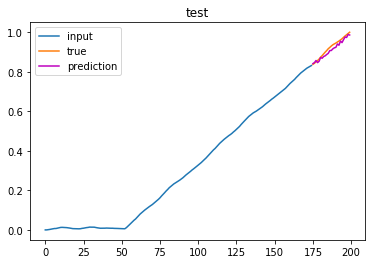

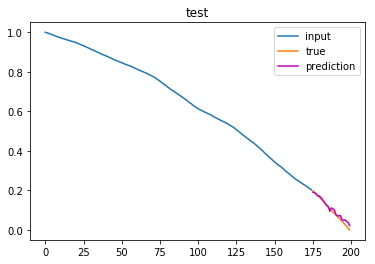

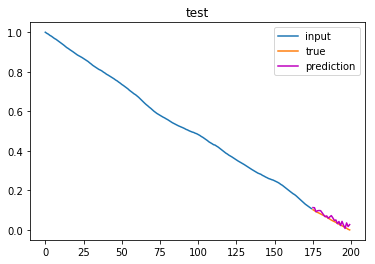

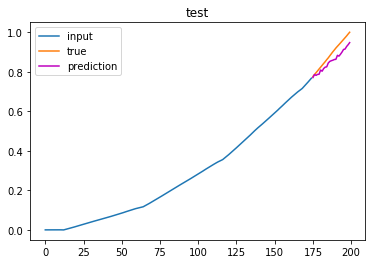

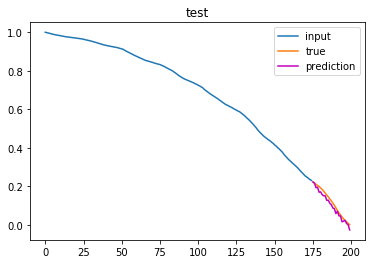

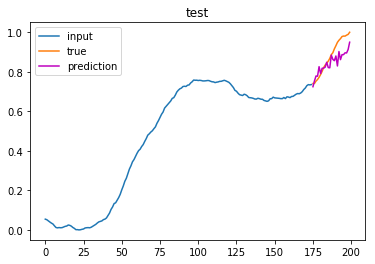

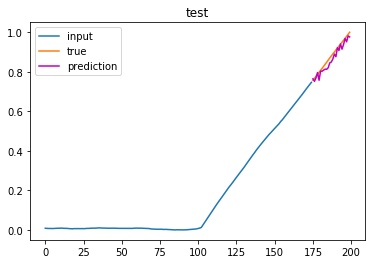

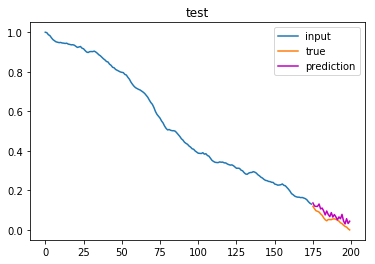

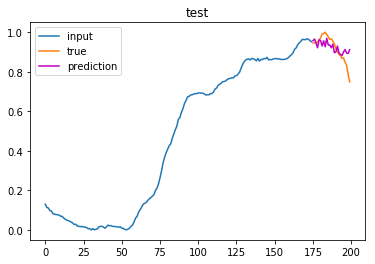

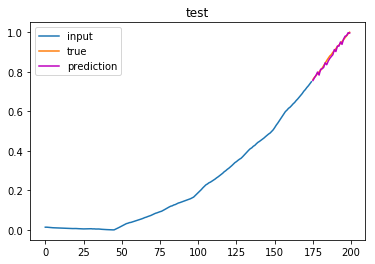

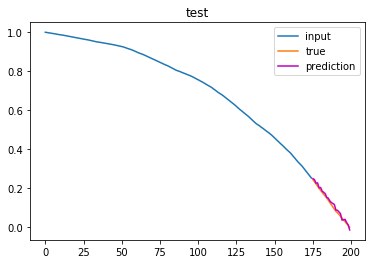

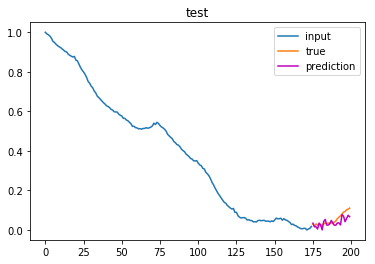

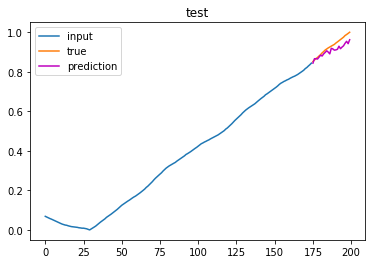

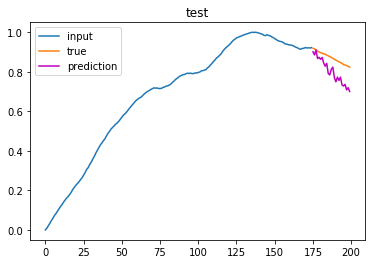

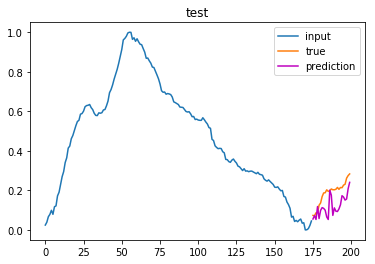

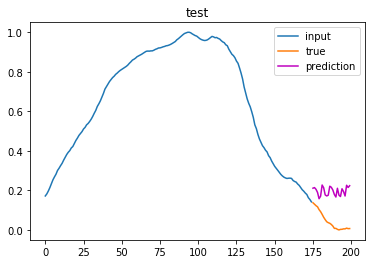

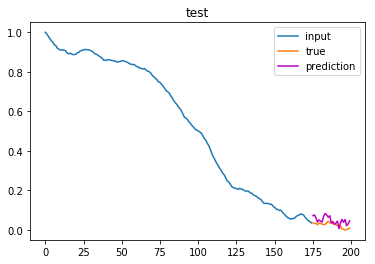

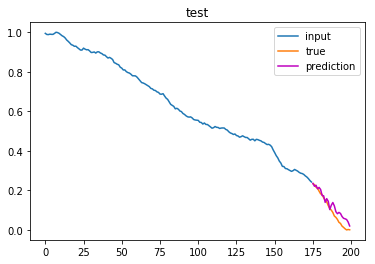

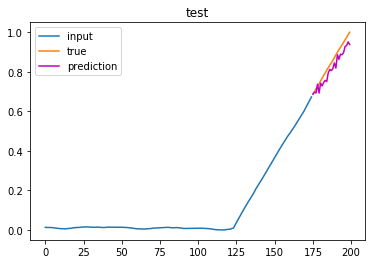

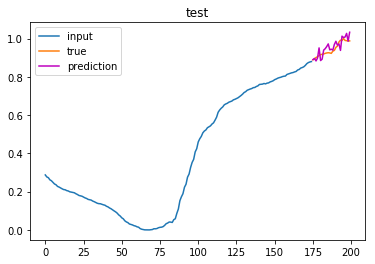

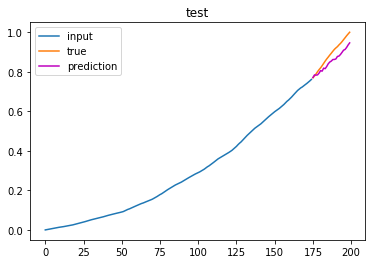

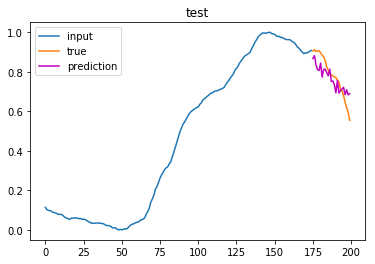

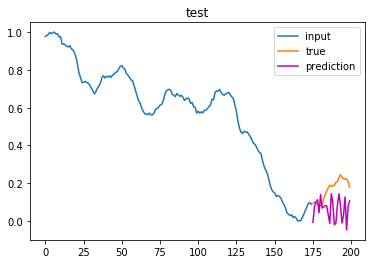

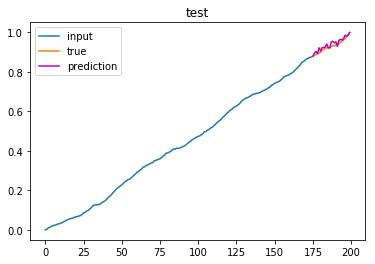

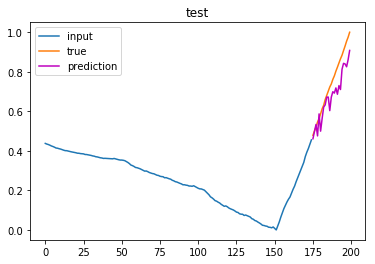

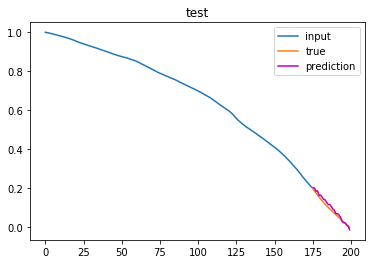

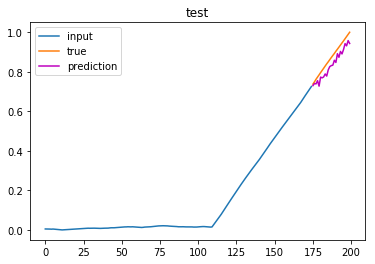

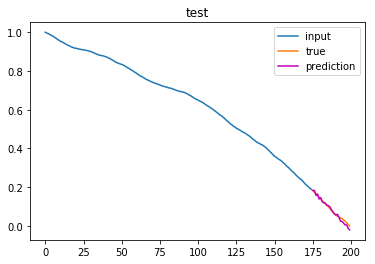

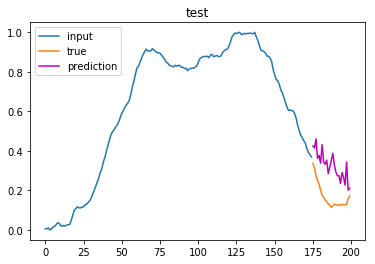

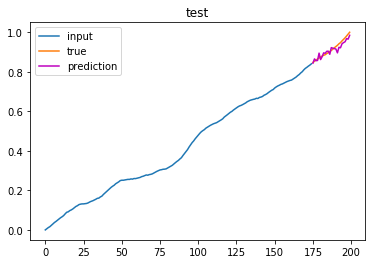

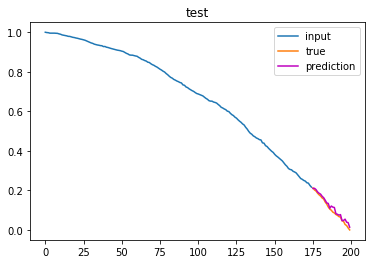

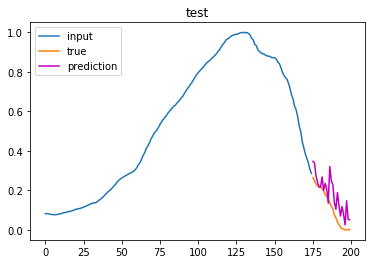

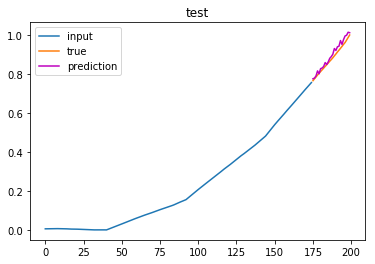

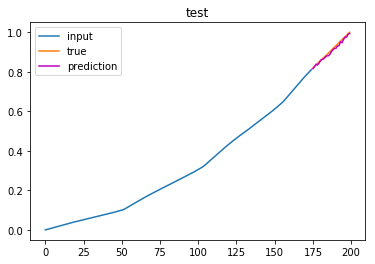

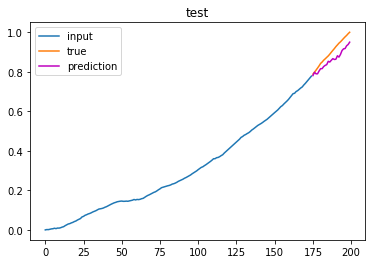

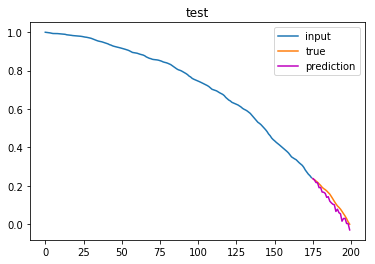

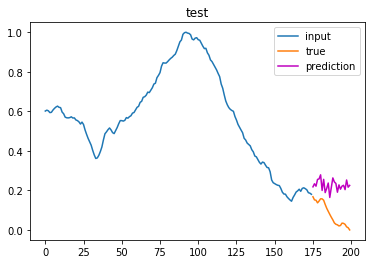

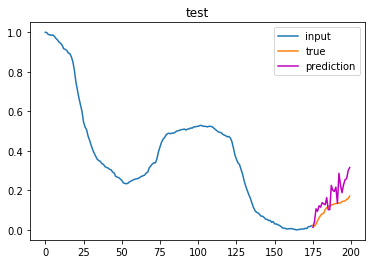

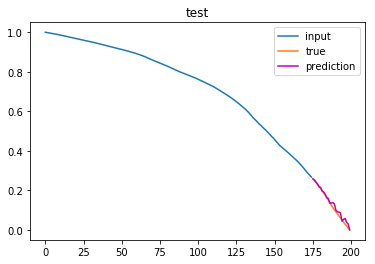

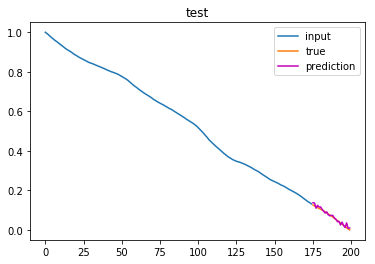

In [63]:
y_pred = model.predict(x_test)

for i in range(40):
    plt.figure()
    plt.plot(range(175), x_test[i], label='input')
    plt.plot(range(175, 200), y_test[i], label='true')
    plt.plot(range(175, 200), y_pred[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

## With *log*

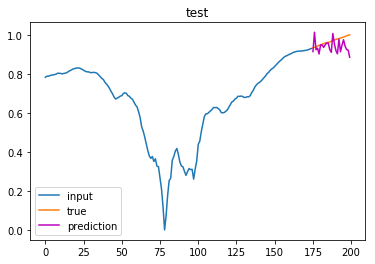

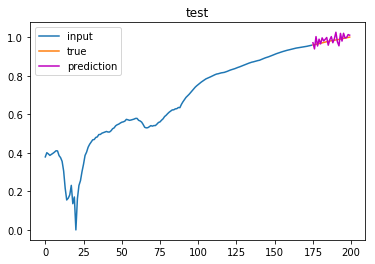

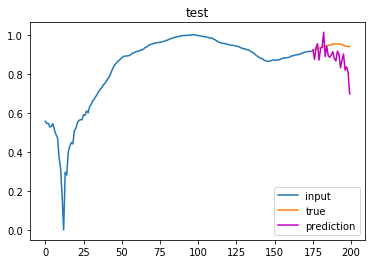

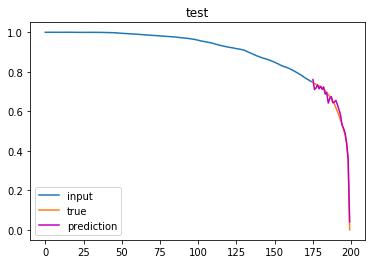

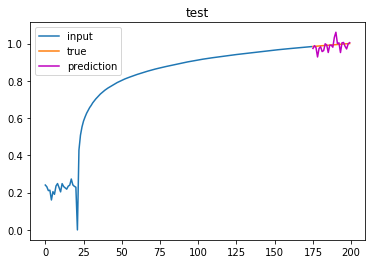

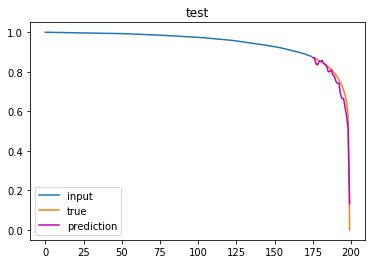

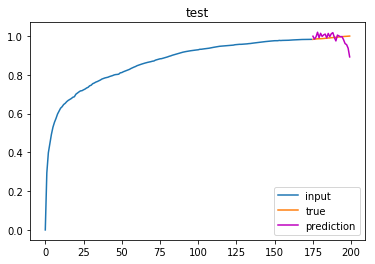

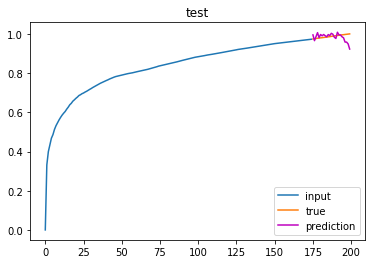

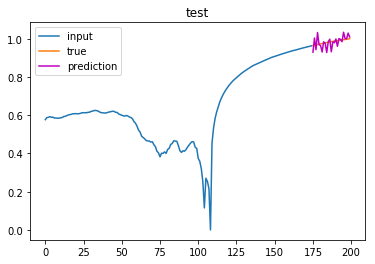

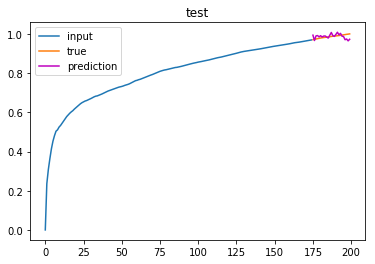

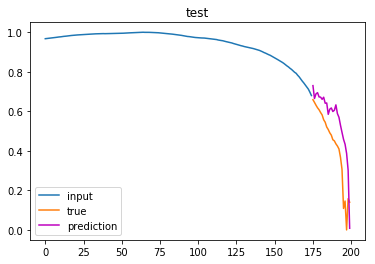

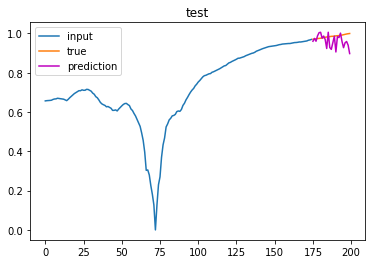

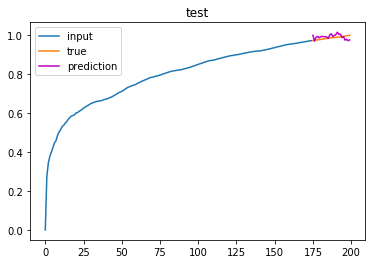

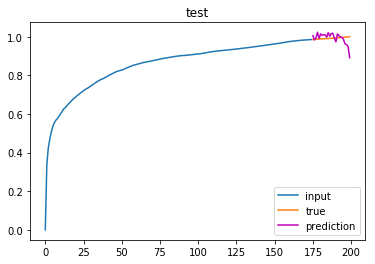

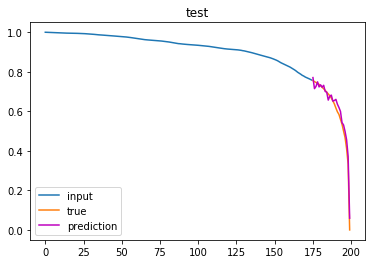

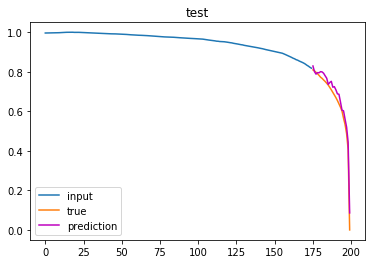

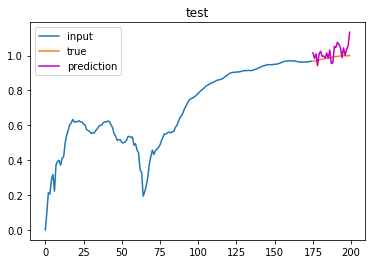

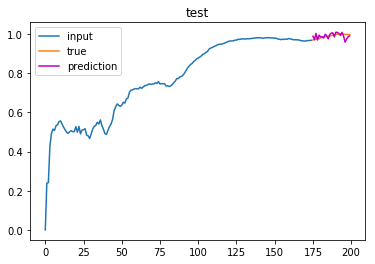

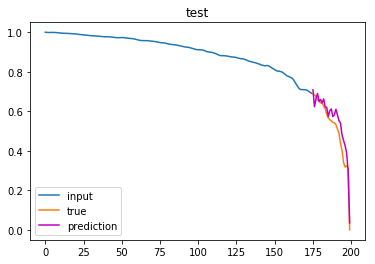

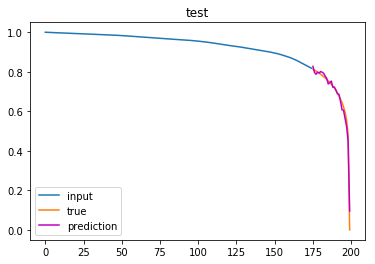

In [15]:
y_pred = model.predict(x_test)

for i in range(20):
    plt.figure()
    plt.plot(range(175), x_test[i], label='input')
    plt.plot(range(175, 200), y_test[i], label='true')
    plt.plot(range(175, 200), y_pred[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

## After Inverse Transform - Low Cluster

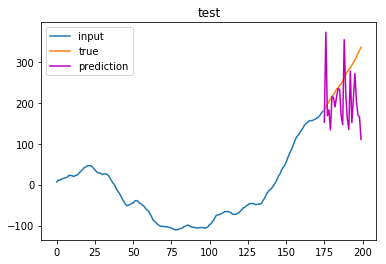

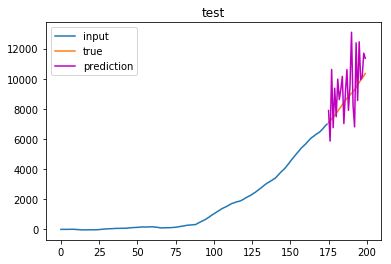

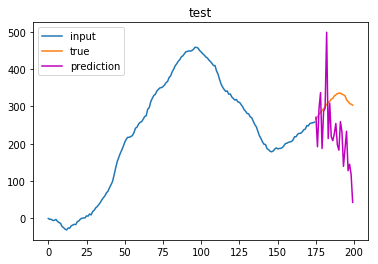

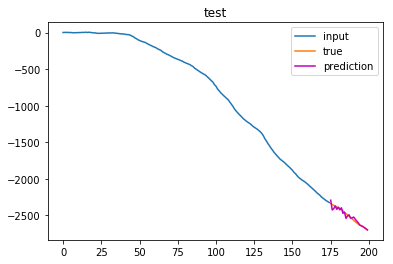

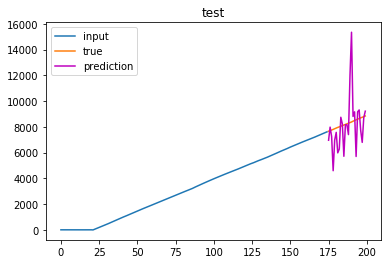

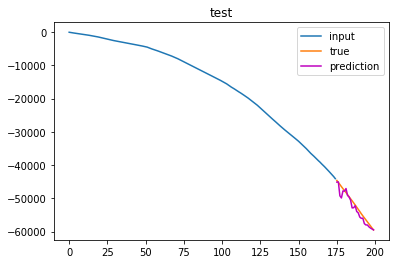

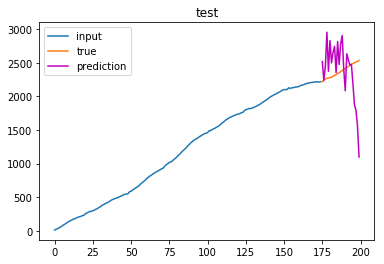

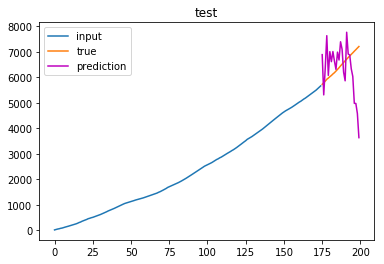

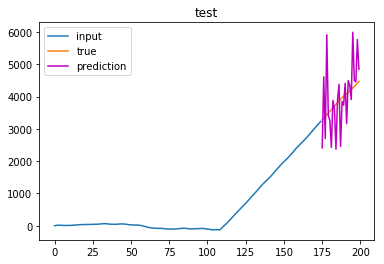

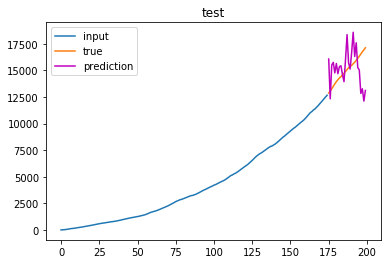

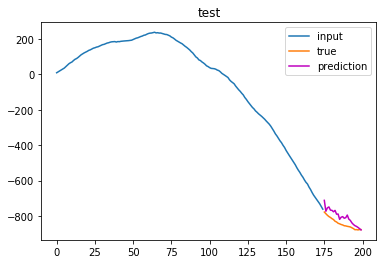

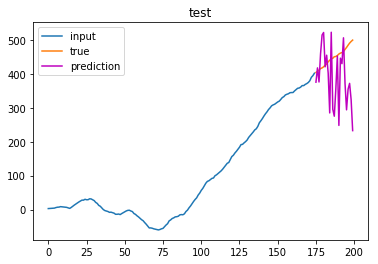

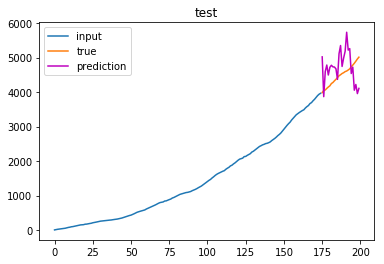

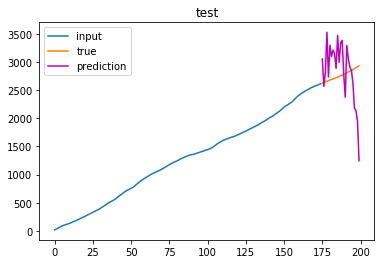

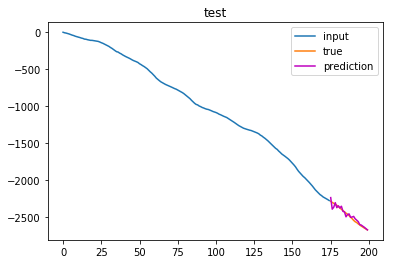

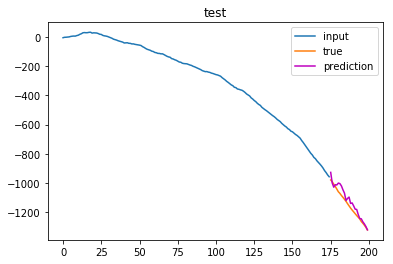

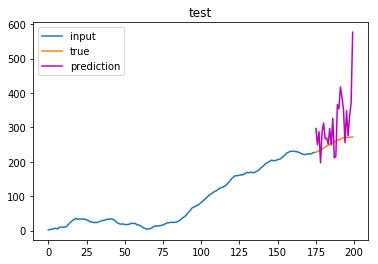

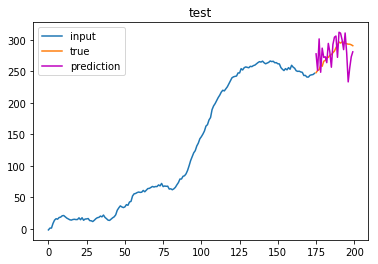

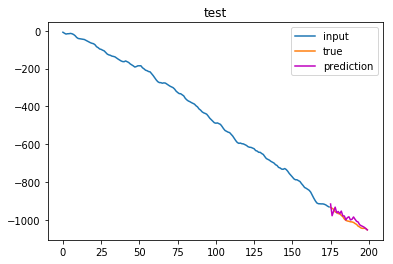

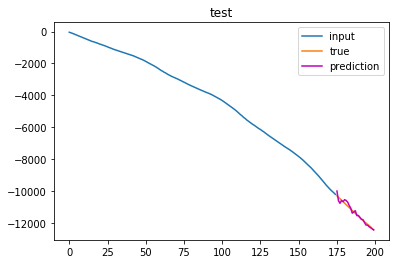

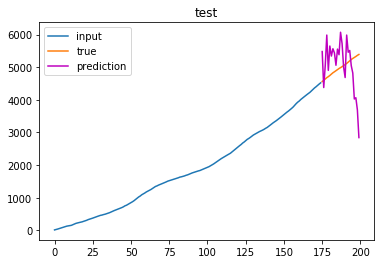

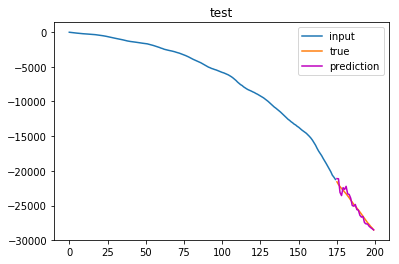

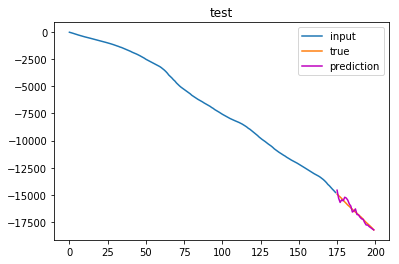

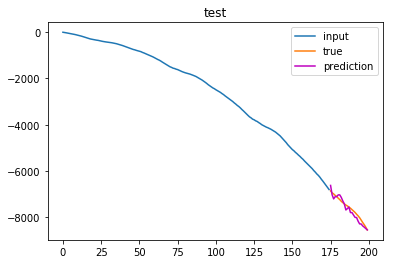

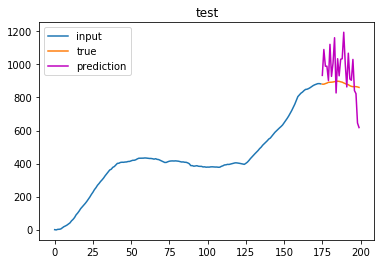

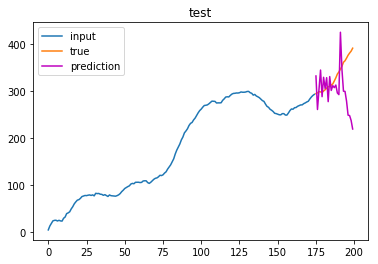

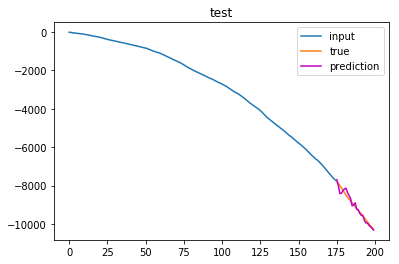

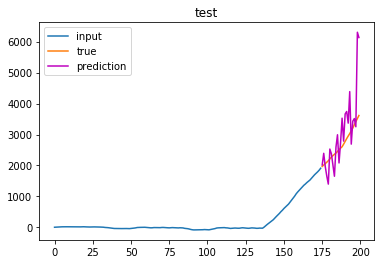

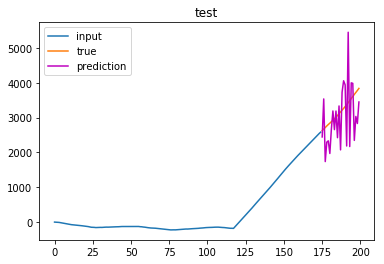

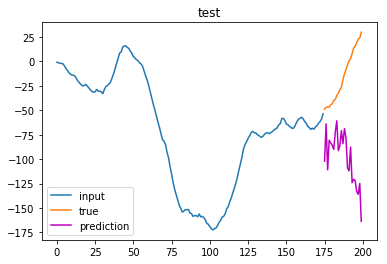

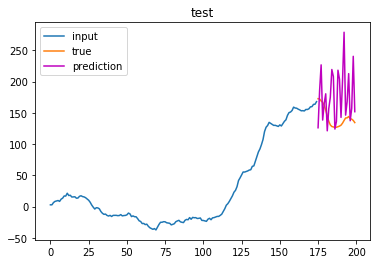

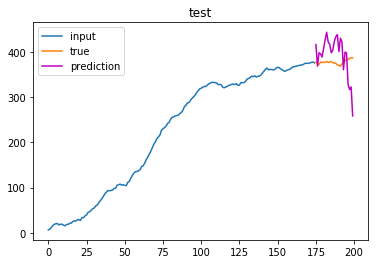

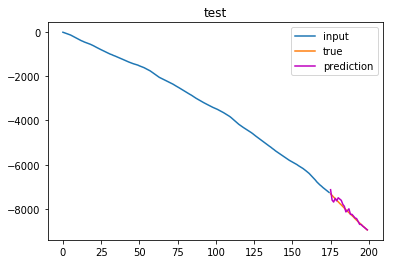

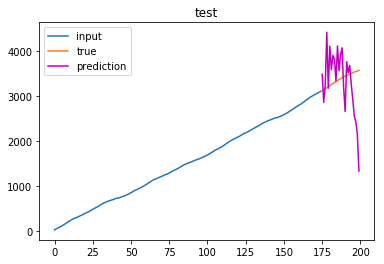

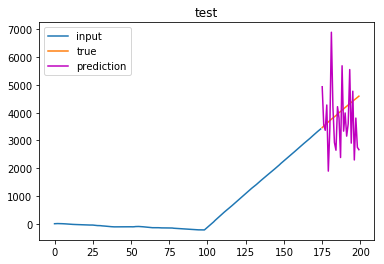

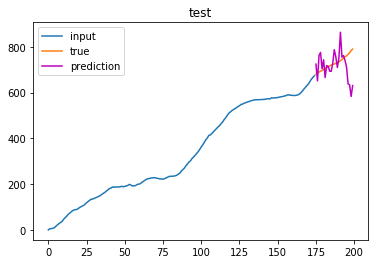

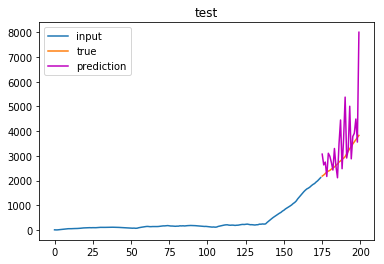

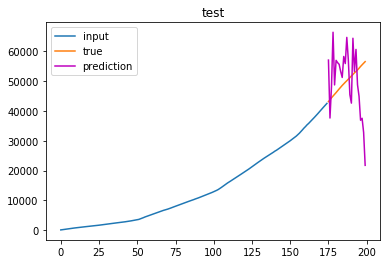

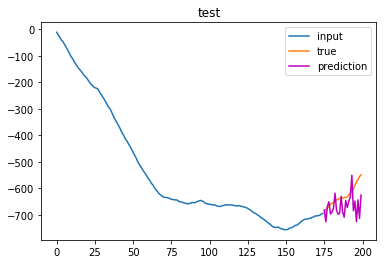

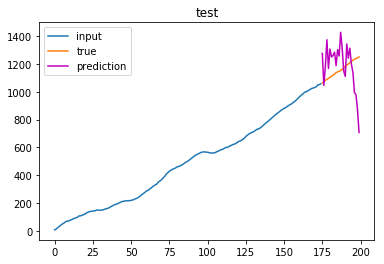

In [16]:
n_steps_for_train = 175
x_all = data_01_norm[:, :n_steps_for_train].reshape(data_01_norm.shape[0], n_steps_for_train, 1)
n = data_01_norm.shape[0] / 2

y_pred = model.predict(x_all)
y_pred_back = inverse_norm(y_pred, scaler01, min01)[n:, :]


for i in range(40):
    plt.figure()
    plt.plot(range(175), data_01[n + i, :175], label='input')
    plt.plot(range(175, 200), data_01[n + i, 175:], label='true')
    plt.plot(range(175, 200), y_pred_back[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

## CNN for "high seasonality cluster"

In [17]:
x_train, y_train, x_test, y_test = train_test_split_reshape(data_09_norm)
model, history = cnn_model(x_train=x_train, y_train=y_train, batch_size=4)

Train on 3500 samples, validate on 1500 samples
Epoch 1/50
 - 1s - loss: 0.0531 - mean_absolute_error: 0.1642 - val_loss: 0.0341 - val_mean_absolute_error: 0.1314
Epoch 2/50
 - 1s - loss: 0.0333 - mean_absolute_error: 0.1291 - val_loss: 0.0300 - val_mean_absolute_error: 0.1194
Epoch 3/50
 - 1s - loss: 0.0301 - mean_absolute_error: 0.1203 - val_loss: 0.0298 - val_mean_absolute_error: 0.1262
Epoch 4/50
 - 1s - loss: 0.0284 - mean_absolute_error: 0.1157 - val_loss: 0.0271 - val_mean_absolute_error: 0.1105
Epoch 5/50
 - 1s - loss: 0.0274 - mean_absolute_error: 0.1129 - val_loss: 0.0261 - val_mean_absolute_error: 0.1090
Epoch 6/50
 - 1s - loss: 0.0264 - mean_absolute_error: 0.1104 - val_loss: 0.0268 - val_mean_absolute_error: 0.1166
Epoch 7/50
 - 1s - loss: 0.0258 - mean_absolute_error: 0.1085 - val_loss: 0.0248 - val_mean_absolute_error: 0.1042
Epoch 8/50
 - 1s - loss: 0.0253 - mean_absolute_error: 0.1071 - val_loss: 0.0243 - val_mean_absolute_error: 0.1021
Epoch 9/50
 - 1s - loss: 0.0247 

In [18]:
naive_prediction_mae()
r_09 = model_mae(model)

naive model = 0.1314
current model = 0.0875


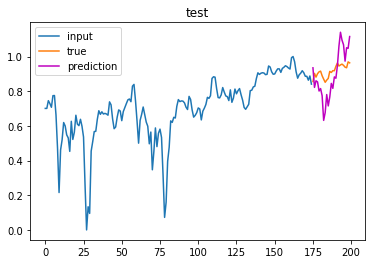

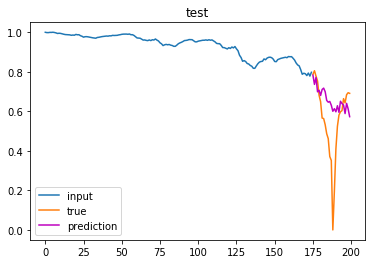

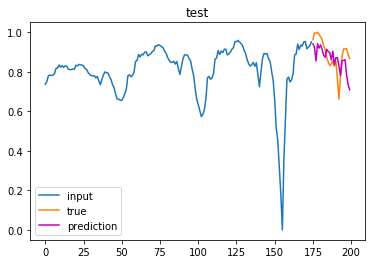

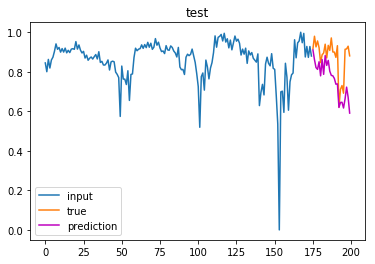

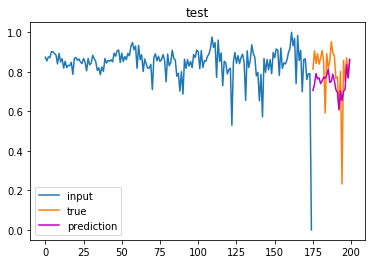

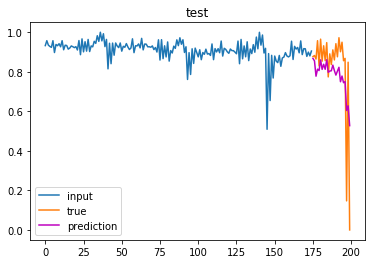

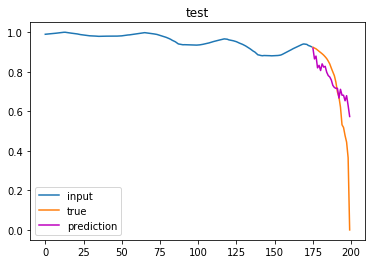

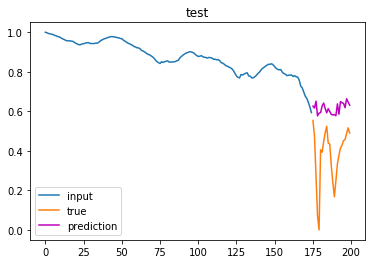

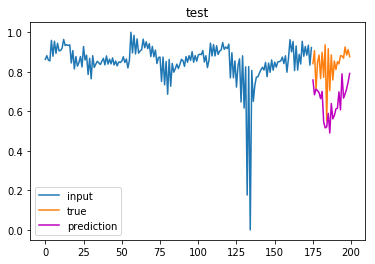

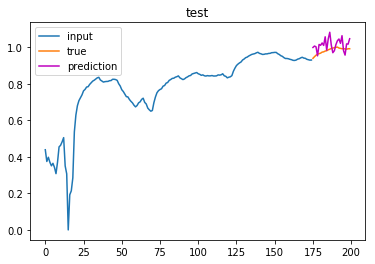

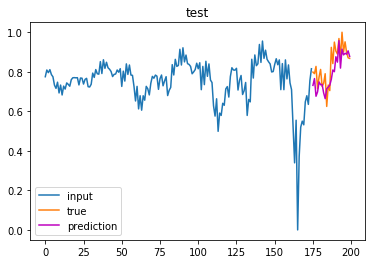

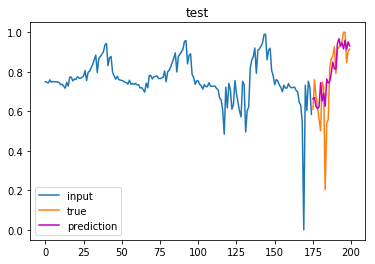

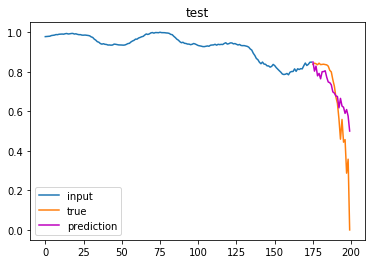

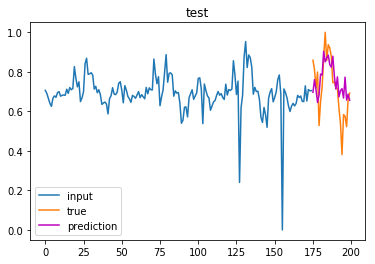

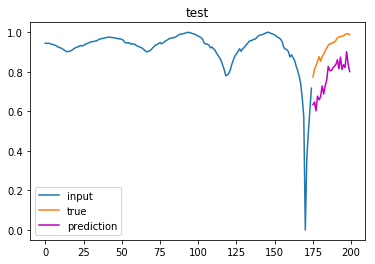

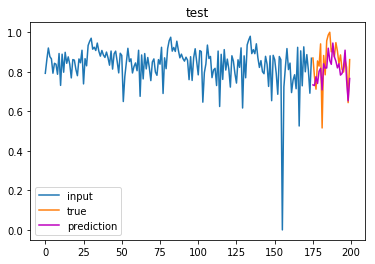

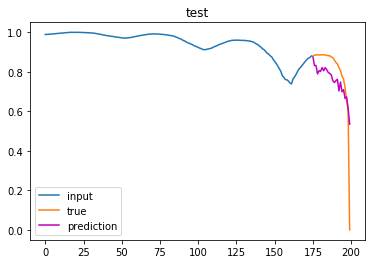

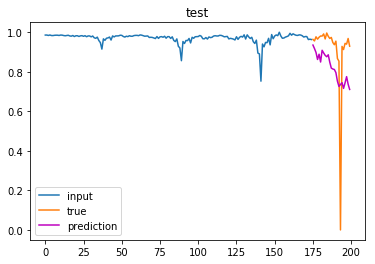

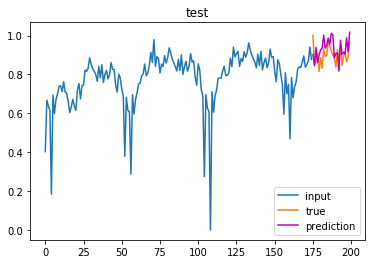

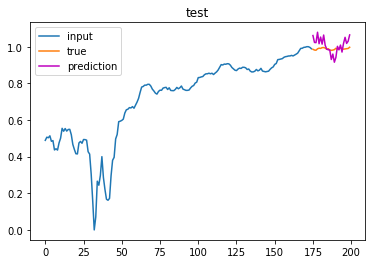

In [19]:
y_pred = model.predict(x_test)

for i in range(20):
    plt.figure()
    plt.plot(range(175), x_test[i], label='input')
    plt.plot(range(175, 200), y_test[i], label='true')
    plt.plot(range(175, 200), y_pred[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

## After Inverse Transform - High Cluster

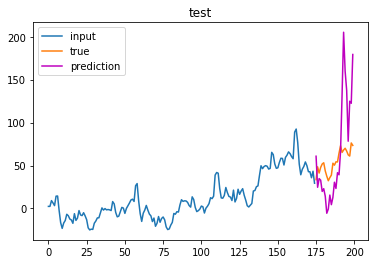

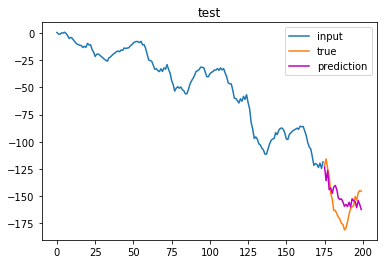

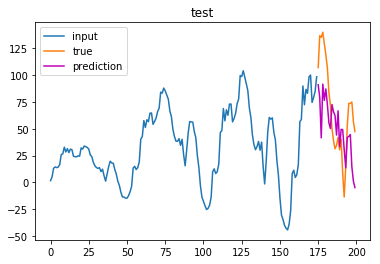

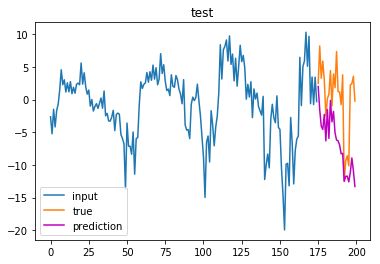

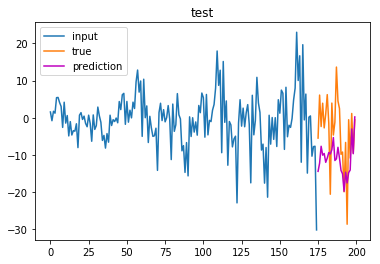

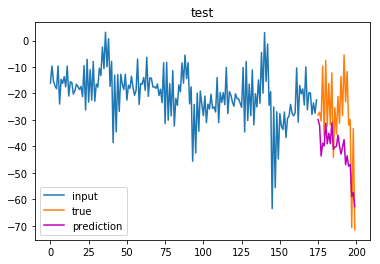

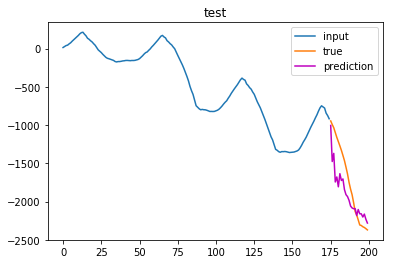

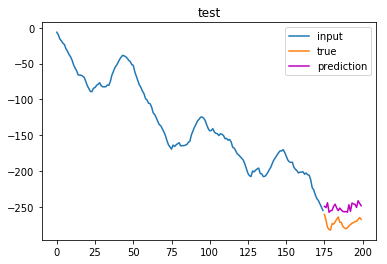

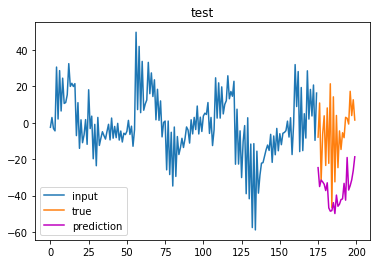

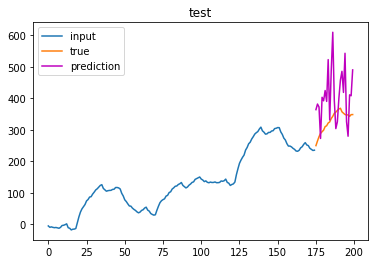

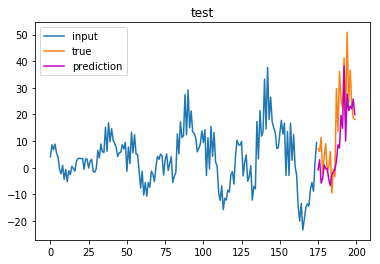

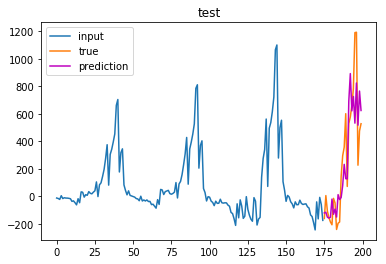

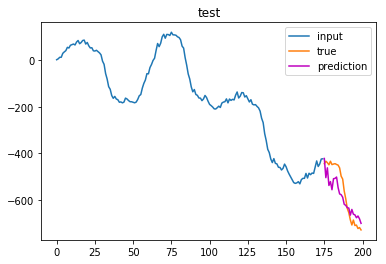

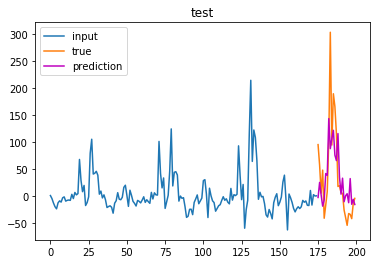

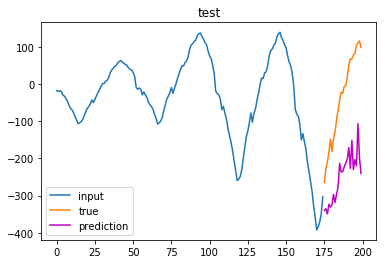

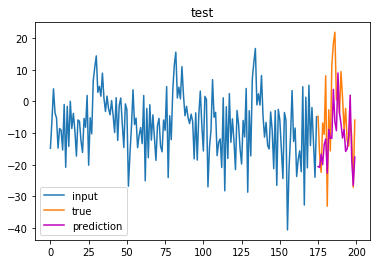

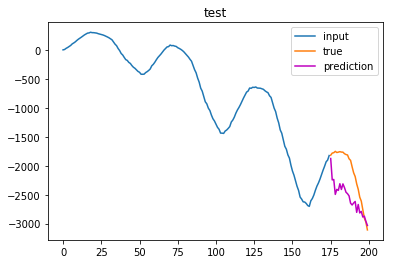

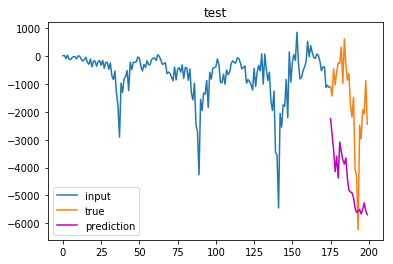

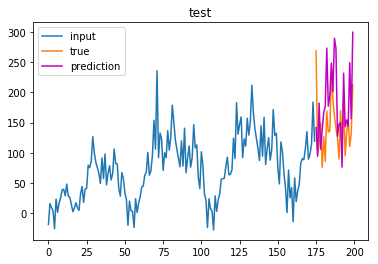

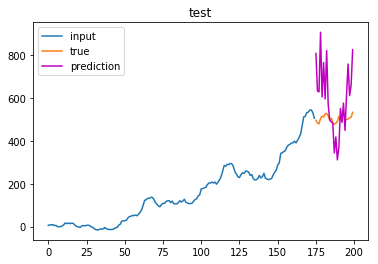

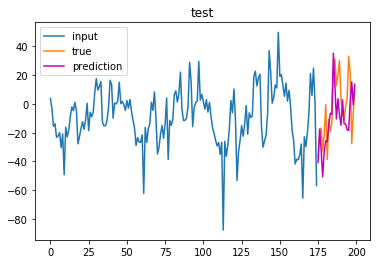

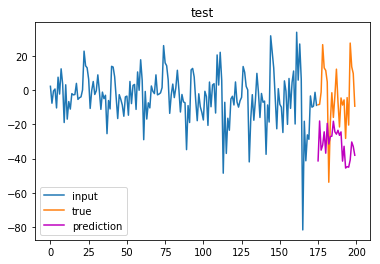

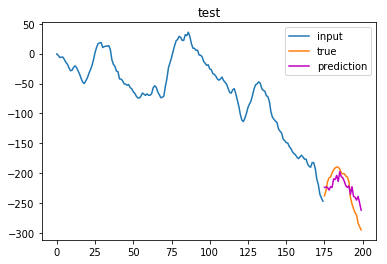

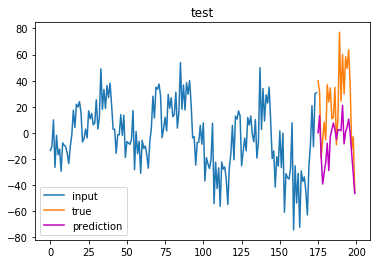

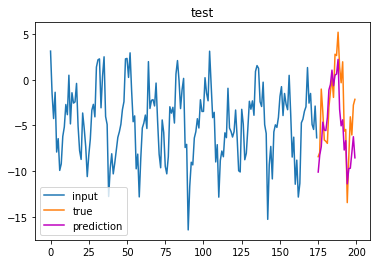

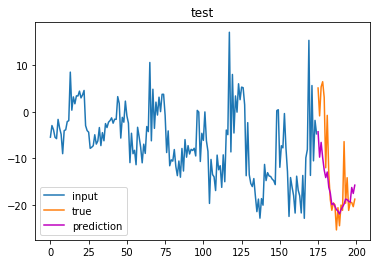

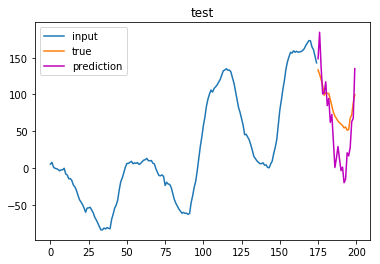

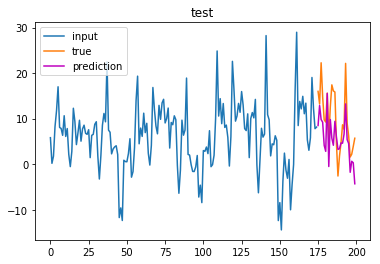

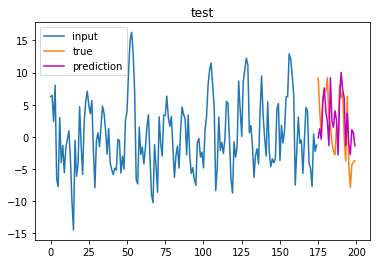

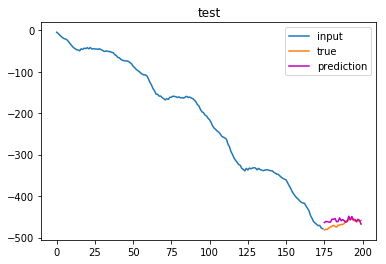

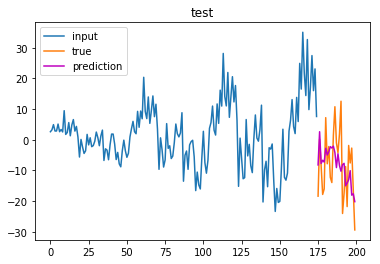

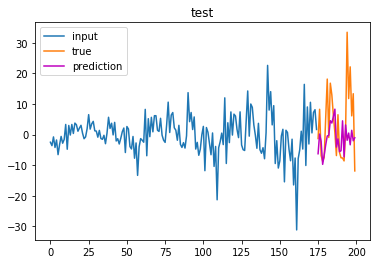

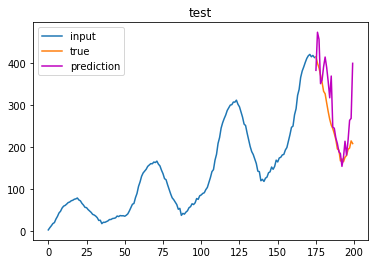

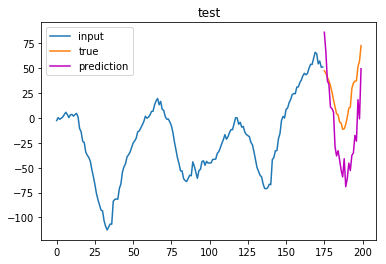

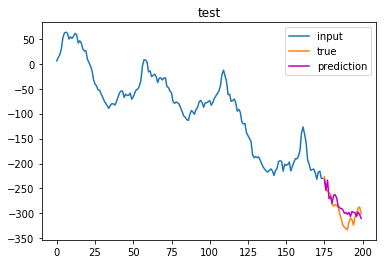

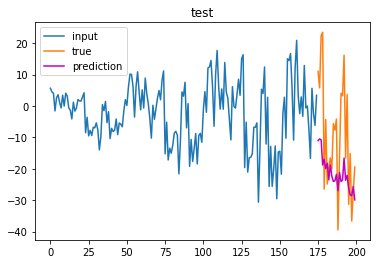

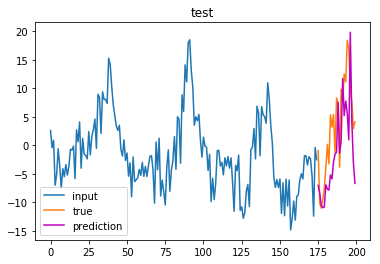

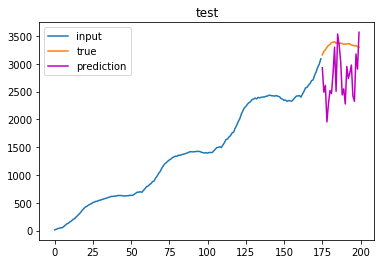

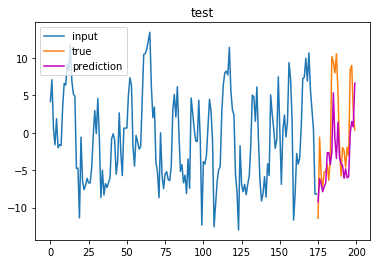

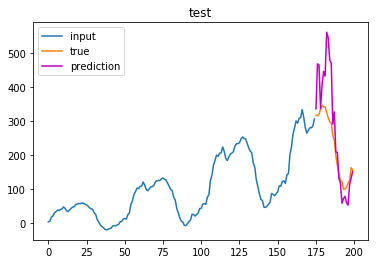

In [20]:
n_steps_for_train = 175
x_all = data_09_norm[:, :n_steps_for_train].reshape(data_09_norm.shape[0], n_steps_for_train, 1)
n = data_09_norm.shape[0] / 2

y_pred = model.predict(x_all)
y_pred_back = inverse_norm(y_pred, scaler09, min09)[n:, :]


for i in range(40):
    plt.figure()
    plt.plot(range(175), data_09[n + i, :175], label='input')
    plt.plot(range(175, 200), data_09[n + i, 175:], label='true')
    plt.plot(range(175, 200), y_pred_back[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

In [21]:

r_01_plus_09 = (r_01 + r_09) / 2
print 'res = {0:0.3f} '.format(r_01_plus_09)

res = 0.064 


In [22]:
print 'res = {0:0.3f} '.format(r_01_09)

res = 0.077 


In [23]:
print 'res = {0:0.2f} %'.format(np.abs(r_01_plus_09 - r_01_09) / r_01_plus_09 * 100)

res = 19.75 %
